# Определение возраста покупателей

**Задача**: Построить модель, которая по фотографии определит приблизительный возраст человека
<br><br>
**Дано**: Набор фотографий людей с указанием возраста
<br><br>
**План решения**:
1. Провести анализ данных распределения возраста на заданной выборке
2. Подобрать нейронную сеть и обучить модель
3. Сделать вывод по результатам обучения модели

## Исследовательский анализ данных

In [1]:
#Импортируем библиотеки и модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#Загрузка данных
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
#Выводим первые 5 объектов
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
#Выводим информацию о датасете
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
#Выводим размер выборки
labels.shape

(7591, 2)

In [6]:
#Выводим числовое описание данных
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

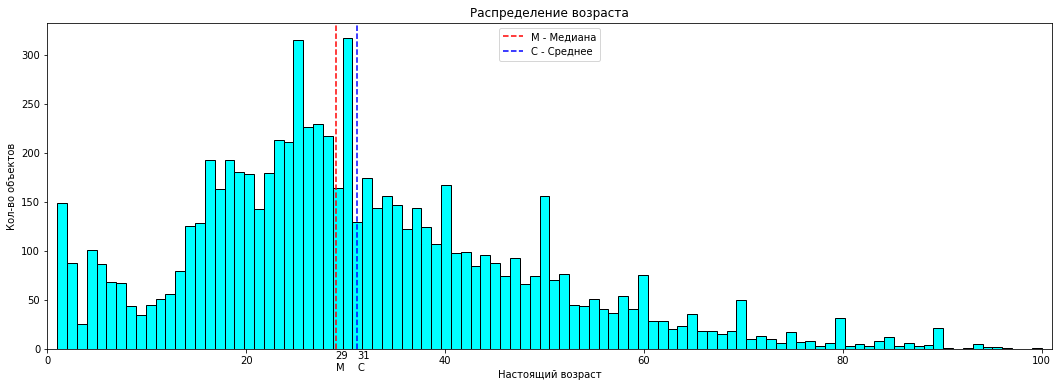

In [7]:
#Построим гистограмму распределения
plt.figure(figsize=[18, 6])
min_ylim, max_ylim  = plt.ylim()
plt.xlim(0, 101)
plt.title(label = 'Распределение возраста')
plt.xlabel('Настоящий возраст')
plt.ylabel('Кол-во объектов')
#Число bins выберм 100, чтобы след. столбик был больше предыдущего на 1 год
plt.hist(labels['real_age'], bins=100, color='cyan', edgecolor='k')
plt.axvline(labels['real_age'].median(), color='red', linestyle='dashed', linewidth=1.5, label='М - Медиана')
plt.text(labels['real_age'].median(), max_ylim*-22, str(int(labels['real_age'].median()))+'\nМ' )
plt.axvline(labels['real_age'].mean(), color='blue', linestyle='dashed', linewidth=1.5, label='С - Среднее')
plt.text(labels['real_age'].mean(), max_ylim*-22, str(int(labels['real_age'].mean()))+'\nС' );
plt.legend(loc="upper center")
plt.show()

In [8]:
#Выделим признаки и целевой признак
features, target = next(train_gen_flow)

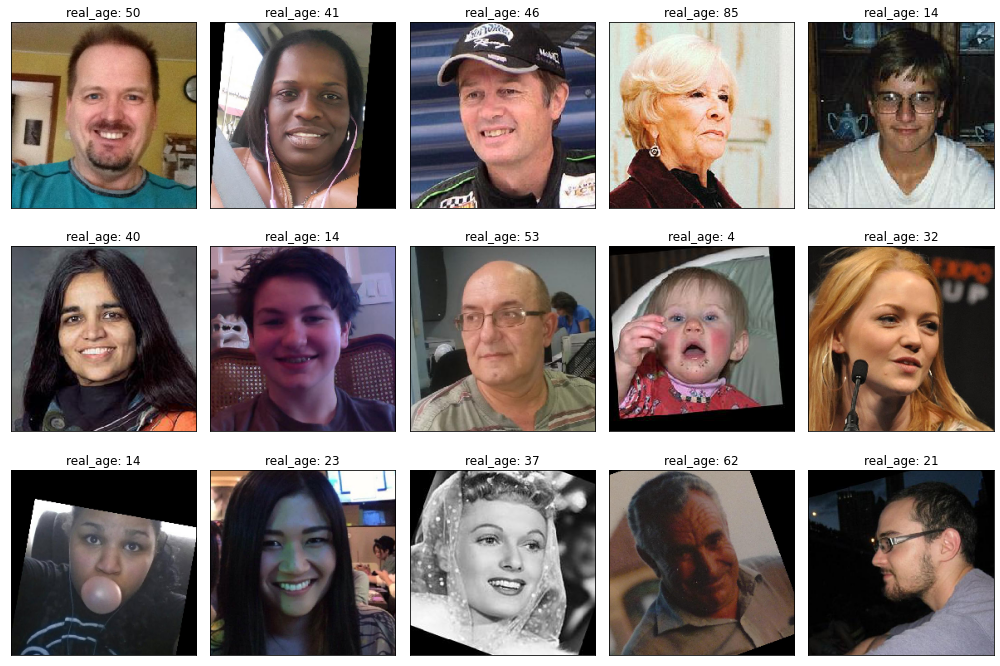

In [9]:
# выводим 15 изображений
fig = plt.figure(figsize=(14,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.title('real_age: '+str(target[i]))
    plt.imshow(features[i])
    #для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**: Гистограмма распределения возраста имеет перекос вправо, т.к. пик распределния находится в левой стороне гистограммы и среднее значение - 31 больше медианы - 29.<br>
После обучения модель будет более точно определять возраст в районе медианы - 29 лет, т.к. кол-во объектов в выборке с этим и близкими значениями больше остальных. С увеличеним возраста покупателя метрика модели будет ухудшаться, т.к. будет уменьшаться кол-во объектов для обучения.<br>
При анализе фотографий в выборке было обнаружено, что ориентация фотографий - вертикальная. Также было обнаружено наличие нестандартных фотографий:
- Чёрно-белых
- Повёрнутых под нестандартным углом
- С отличающимися от большинства фотографий размерами

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv('/'+ path + '/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, 
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= '/' + path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345) 
    return train_datagen_flow
 
 
def load_test(path):
    labels = pd.read_csv('/'+ path + '/labels.csv')
    val_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    val_datagen_flow = val_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= '/' + path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'validation',
        seed=12345)   
    return val_datagen_flow

 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False) 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error', 
             metrics=['mean_absolute_error']) 
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 104s - loss: 292.7349 - mean_absolute_error: 12.7091 - val_loss: 469.1969 - val_mean_absolute_error: 16.5685
Epoch 2/10
178/178 - 95s - loss: 138.9669 - mean_absolute_error: 9.0188 - val_loss: 501.7922 - val_mean_absolute_error: 17.2850
Epoch 3/10
178/178 - 95s - loss: 121.6302 - mean_absolute_error: 8.3781 - val_loss: 382.8362 - val_mean_absolute_error: 14.6322
Epoch 4/10
178/178 - 96s - loss: 110.5313 - mean_absolute_error: 8.0196 - val_loss: 168.5442 - val_mean_absolute_error: 9.9718
Epoch 5/10
178/178 - 100s - loss: 95.5847 - mean_absolute_error: 7.4536 - val_loss: 198.7107 - val_mean_absolute_error: 11.1104
Epoch 6/10
178/178 - 103s - loss: 91.0962 - mean_absolute_error: 7.2845 - val_loss: 140.4008 - val_mean_absolute_error: 8.8047
Epoch 7/10
178/178 - 105s - loss: 84.9688 - mean_absolute_error: 7.0040 - val_loss: 135.8144 - val_mean_absolute_error: 8.8918
Epoch 8/10
178/178 - 103s - loss: 74.7549 - mean_absolute_error: 6.6433 - val_loss: 156.7181 - val_mean_absolute_error: 9.4333
Epoch 9/10
178/178 - 104s - loss: 75.1947 - mean_absolute_error: 6.6804 - val_loss: 100.7800 - val_mean_absolute_error: 7.5918
Epoch 10/10
178/178 - 103s - loss: 68.5878 - mean_absolute_error: 6.3319 - val_loss: 99.7626 - val_mean_absolute_error: 7.4555
Test MAE: 7.4555

```

## Анализ обученной модели

Для выполнения задачи была выбрана свёрточная сеть с архитектурой ResNet50. Метрика качества - MAE. В ходе обучения модели было достигнуто значение MAE = 7.455 на тестовой выборке.